# **1: Konfigurasi & Setup Awal**

In [1]:
import os
import random
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.utils.spectral_norm as spectral_norm

# Konfigurasi Parameter
params = {
    'zip_path': 'anime_faces.zip',   # Nama file zip dataset
    'data_root': 'dataset_extracted', # Folder tujuan ekstrak
    'workers': 0,        
    'batch_size': 64,    # Jumlah gambar per proses
    'image_size': 64,    # Ukuran gambar 64x64 pixel
    'nc': 3,             # Jumlah channel warna (3 = RGB)
    'nz': 100,           # Ukuran vektor noise (bahan baku gambar)
    'ngf': 64,           # Ukuran fitur map Generator
    'ndf': 64,           # Ukuran fitur map Discriminator
    'num_epochs': 70,  # Jumlah epoch pelatihan
    'lr': 0.0001,        # Learning rate (kecepatan belajar)
    'beta1': 0.5,        # Parameter optimizer Adam
    'seed': 999          # Angka acak biar hasil konsisten
}

# Set seed supaya hasil bisa direproduksi
random.seed(params['seed'])
torch.manual_seed(params['seed'])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Sistem Siap. Menggunakan Device: {device}")

Sistem Siap. Menggunakan Device: cuda:0


# **2: Persiapan Data (Extract & Load)**

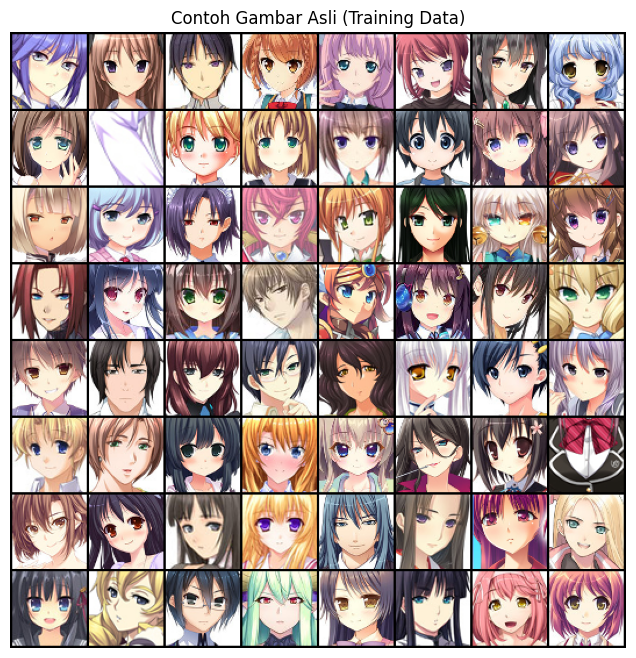

Data siap diproses. Total gambar: 21551


In [2]:
# 1. Ekstrak Dataset (jika belum ada)
if os.path.exists(params['zip_path']):
    if not os.path.exists(params['data_root']):
        print("Sedang mengekstrak dataset, mohon tunggu...")
        with zipfile.ZipFile(params['zip_path'], 'r') as zip_ref:
            zip_ref.extractall(params['data_root'])
else:
    print(f"Error: File {params['zip_path']} tidak ditemukan.")

# 2. Cari folder gambar yang valid
target_root = params['data_root']
for root, dirs, files in os.walk(params['data_root']):
    # Cek apakah ada file gambar png/jpg di folder ini
    if any(f.lower().endswith(('.png', '.jpg')) for f in files):
        target_root = os.path.dirname(root)
        break

# 3. Buat Dataset & DataLoader
dataset = dsets.ImageFolder(root=target_root,
                           transform=transforms.Compose([
                               transforms.Resize(params['image_size']),
                               transforms.CenterCrop(params['image_size']),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=params['batch_size'],
                                         shuffle=True, 
                                         num_workers=params['workers'])

# 4. Tampilkan contoh gambar asli
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Contoh Gambar Asli (Training Data)")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

print(f"Data siap diproses. Total gambar: {len(dataset)}")

# **3: Arsitektur Model (Generator & Discriminator)**

In [3]:
# Inisialisasi Bobot (Tetap sama)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Kelas Generator (Tetap sama, Spectral Norm biasanya fokus di Discriminator)
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Kelas Discriminator (REVISI: Ditambahkan Spectral Normalization)
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Layer 1 + Spectral Norm
            spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 2 + Spectral Norm
            spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 3 + Spectral Norm
            spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 4 + Spectral Norm
            spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Dropout(0.5),
            
            # Output Layer: Pakai Sigmoid untuk BCELoss
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() 
        )

    def forward(self, input):
        return self.main(input).view(-1)



# **4: Inisialisasi Model & Optimizer**

In [4]:
# Membuat objek model
netG = Generator(params['nz'], params['ngf'], params['nc']).to(device)
netD = Discriminator(params['nc'], params['ndf']).to(device)

# Terapkan inisialisasi bobot
netG.apply(weights_init)
netD.apply(weights_init)

# Fungsi Loss (Menggunakan Binary Cross Entropy)
criterion = nn.BCELoss()

# Setup Optimizer (Menggunakan Adam)
optimizerD = optim.Adam(netD.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0004, betas=(params['beta1'], 0.999))

# Noise tetap untuk memantau perkembangan gambar
fixed_noise = torch.randn(64, params['nz'], 1, 1, device=device)
real_label = 1.
fake_label = 0.

print("Model dan Optimizer berhasil diinisialisasi.")

Model dan Optimizer berhasil diinisialisasi.


# **5: Proses Training (Loop Utama)**

In [5]:
img_list = []
G_losses = []
D_losses = []

print("Mulai Proses Training...")

for epoch in range(params['num_epochs']):
    for i, data in enumerate(dataloader, 0):

        # (1) Update jaringan D (Discriminator)
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        real_label_smoothed = 0.9
        label = torch.full((b_size,), real_label_smoothed, dtype=torch.float, device=device)
        
        noise_level = 0.1 # Bisa diatur 0.05 sampai 0.1
        noise_gangguan = torch.randn_like(real_cpu) * noise_level
        real_cpu_with_noise = real_cpu + noise_gangguan
        
        # Latih dengan gambar asli
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        # Latih dengan gambar palsu (buatan Generator)
        noise = torch.randn(b_size, params['nz'], 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update jaringan G (Generator)
        netG.zero_grad()
        label.fill_(real_label)  # label palsu dianggap asli agar generator belajar
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Simpan nilai Loss untuk grafik
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Tampilkan status log
        if i % 100 == 0:
            print(f'[{epoch}/{params["num_epochs"]}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}')

    # Simpan hasil generate gambar per epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

print("Training selesai!")


Mulai Proses Training...
[0/70][0/337] Loss_D: 1.6361 Loss_G: 4.3853
[0/70][100/337] Loss_D: 1.8149 Loss_G: 4.7819
[0/70][200/337] Loss_D: 1.8690 Loss_G: 6.0620
[0/70][300/337] Loss_D: 1.1245 Loss_G: 2.2670
[1/70][0/337] Loss_D: 1.4730 Loss_G: 3.5836
[1/70][100/337] Loss_D: 1.4456 Loss_G: 3.2015
[1/70][200/337] Loss_D: 1.4401 Loss_G: 3.4801
[1/70][300/337] Loss_D: 1.3693 Loss_G: 2.6213
[2/70][0/337] Loss_D: 1.7334 Loss_G: 3.7185
[2/70][100/337] Loss_D: 1.5044 Loss_G: 1.8977
[2/70][200/337] Loss_D: 1.9384 Loss_G: 4.3677
[2/70][300/337] Loss_D: 1.2306 Loss_G: 2.9980
[3/70][0/337] Loss_D: 1.4426 Loss_G: 3.0072
[3/70][100/337] Loss_D: 1.2665 Loss_G: 2.3300
[3/70][200/337] Loss_D: 1.4184 Loss_G: 1.9659
[3/70][300/337] Loss_D: 1.3035 Loss_G: 2.7273
[4/70][0/337] Loss_D: 1.1870 Loss_G: 2.7267
[4/70][100/337] Loss_D: 1.2065 Loss_G: 1.6228
[4/70][200/337] Loss_D: 1.2640 Loss_G: 2.7234
[4/70][300/337] Loss_D: 1.0413 Loss_G: 3.2243
[5/70][0/337] Loss_D: 1.1920 Loss_G: 2.7092
[5/70][100/337] Loss_

# **6: Evaluasi Hasil & Grafik**

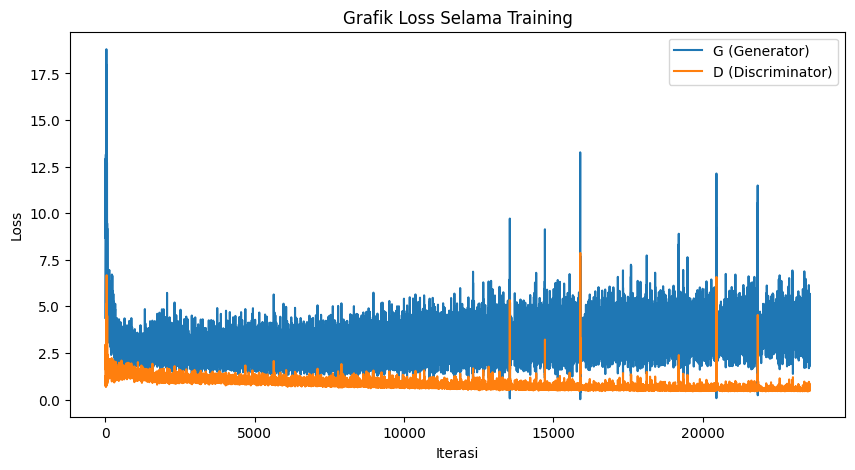

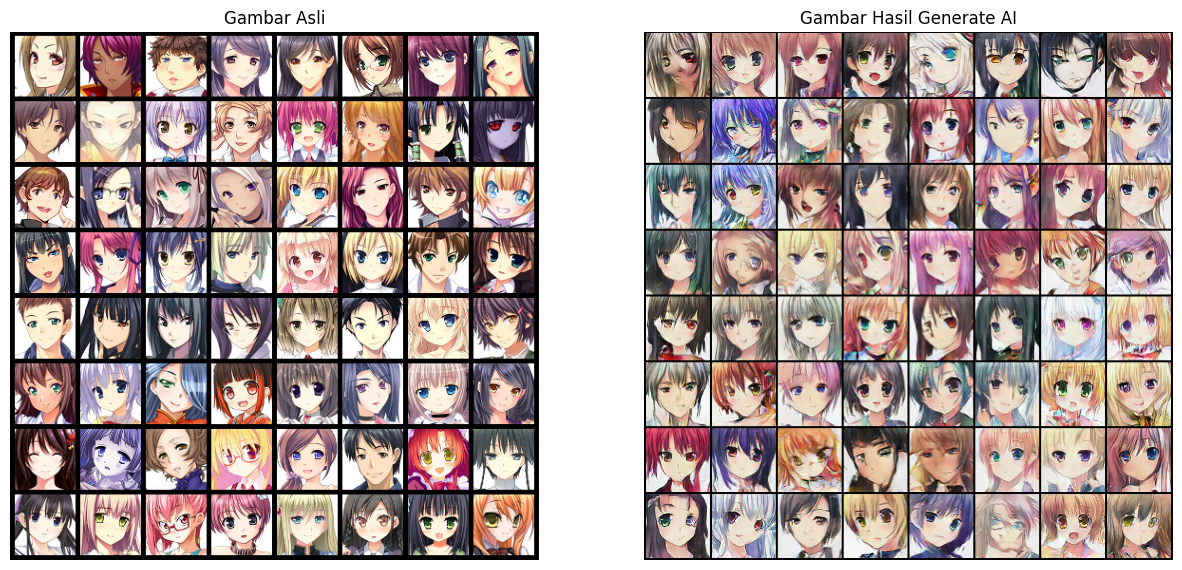

In [6]:
# 1. Plot Grafik Loss (Generator vs Discriminator)
plt.figure(figsize=(10,5))
plt.title("Grafik Loss Selama Training")
plt.plot(G_losses, label="G (Generator)")
plt.plot(D_losses, label="D (Discriminator)")
plt.xlabel("Iterasi")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 2. Bandingkan Gambar Asli vs Buatan AI
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
# Gambar Asli
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Gambar Asli")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Gambar Buatan AI (Terakhir)
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Gambar Hasil Generate AI")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# **7: Simpan Model (Save) & Tes Ulang**

Model berhasil disimpan di folder: checkpoints
Model berhasil dimuat ulang (Load State Dict).


C:\Users\NITRO 5\AppData\Local\Temp\ipykernel_28540\3463388515.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_eval.load_state_dict(torch.load(weights_path))


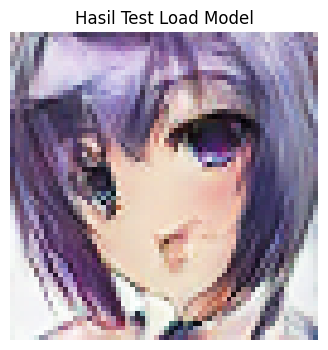

In [7]:
# Simpan Model Hasil Training 
import os

model_dir = 'checkpoints'
os.makedirs(model_dir, exist_ok=True)

# Simpan bobotnya saja (hemat penyimpanan)
torch.save(netG.state_dict(), os.path.join(model_dir, 'generator_final.pth'))
torch.save(netD.state_dict(), os.path.join(model_dir, 'discriminator_final.pth'))

print(f"Model berhasil disimpan di folder: {model_dir}")

#  Cek Load Model (Tes Jalan) 
# Mencoba memuat ulang model untuk memastikan file tidak rusak
device_eval = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gen_eval = Generator(params['nz'], params['ngf'], params['nc']).to(device_eval)

# Load bobot yang baru disimpan
weights_path = os.path.join(model_dir, 'generator_final.pth')
if os.path.exists(weights_path):
    gen_eval.load_state_dict(torch.load(weights_path))
    gen_eval.eval()
    print("Model berhasil dimuat ulang (Load State Dict).")
else:
    print("Error: File model tidak ditemukan.")

# Coba generate 1 gambar sample
with torch.no_grad():
    sample_noise = torch.randn(1, params['nz'], 1, 1, device=device_eval)
    generated = gen_eval(sample_noise).detach().cpu()

# Tampilkan hasilnya
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Hasil Test Load Model")
plt.imshow(np.transpose(vutils.make_grid(generated, padding=2, normalize=True), (1,2,0)))
plt.show()


# **SIMPAN GAMBAR KE FOLDER RESULTS OTOMATIS**

In [ ]:
import os

# 1. Pastikan folder results ada
os.makedirs('results', exist_ok=True)

# 2. Simpan Grafik Loss
if 'G_losses' in locals() and 'D_losses' in locals() and len(G_losses) > 0:
    plt.figure(figsize=(10,5))
    plt.title("Grafik Loss Selama Training")
    plt.plot(G_losses, label="G (Generator)")
    plt.plot(D_losses, label="D (Discriminator)")
    plt.xlabel("Iterasi")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('results/loss_graph.png') # Perintah simpan
    plt.close()
    print("Berhasil menyimpan: results/loss_graph.png")
else:
    print("Data Loss tidak ditemukan")

# 3. Simpan Gambar Epoch 1 (Awal) dan Epoch Terakhir
if 'img_list' in locals() and len(img_list) > 0:
    # Simpan Epoch 1 (index 0)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Epoch 1")
    plt.imshow(np.transpose(img_list[0],(1,2,0)))
    plt.savefig('results/epoch_1.png')
    plt.close()
    print("Berhasil menyimpan: results/epoch_1.png")

    # Simpan Epoch Terakhir (index -1)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Final Result")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.savefig('results/epoch_70_final.png')
    plt.close()
    print("Berhasil menyimpan: results/epoch_70_final.png")
else:
    print("Data img_list tidak ditemukan")

Berhasil menyimpan: results/loss_graph.png
Berhasil menyimpan: results/epoch_1.png
Berhasil menyimpan: results/epoch_50_final.png


# **Rekap akurasi, Presisi, Recal, F1-Score**

In [9]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. DEFINISI FUNGSI
def hitung_metrik_evaluasi(model_diskriminator, dataloader_asli, model_generator):
    print("Sedang melakukan evaluasi")
    
    y_true = [] # Label Asli
    y_pred = [] # Prediksi Model
    
    # Cek device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Pastikan model di mode evaluasi
    model_diskriminator.to(device)
    model_generator.to(device)
    model_diskriminator.eval()
    
    with torch.no_grad():
        # A. Tes dengan Gambar ASLI (Dari Dataset)
        for i, data in enumerate(dataloader_asli):
            # Ambil gambar asli saja (abaikan label bawaan dataset)
            imgs_asli = data[0].to(device)
            
            # Diskriminator memprediksi
            output = model_diskriminator(imgs_asli).view(-1).cpu()
            
            # Ubah probabilitas jadi 0 atau 1 (Threshold 0.5)
            # Jika > 0.5 anggap 1 (Real), jika < 0.5 anggap 0 (Fake)
            prediksi = (output > 0.5).int().numpy()
            
            # Masukkan ke list
            y_true.extend([1] * len(prediksi)) # Kita tahu ini gambar asli, jadi labelnya 1
            y_pred.extend(prediksi)
            
            # Batasi jumlah sampel biar tidak terlalu lama
            if i > 50: break 

        # B. Tes dengan Gambar PALSU (Dari Generator)
        # Buat noise (bahan baku gambar palsu)
        jumlah_palsu = len(y_true) # Samakan jumlahnya dengan data asli yg dites
        noise = torch.randn(jumlah_palsu, 100, 1, 1, device=device)
        
        # Generator bikin gambar
        imgs_palsu = model_generator(noise)
        
        # Diskriminator memprediksi gambar palsu
        output_palsu = model_diskriminator(imgs_palsu).view(-1).cpu()
        prediksi_palsu = (output_palsu > 0.5).int().numpy()
        
        # Masukkan ke list
        y_true.extend([0] * len(prediksi_palsu)) # Kita tahu ini palsu, labelnya 0
        y_pred.extend(prediksi_palsu)

    # 2. HITUNG SKOR
    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred, zero_division=0) * 100
    rec = recall_score(y_true, y_pred, zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, zero_division=0) * 100
    
    # 3. TAMPILKAN HASIL
    print("\n" + "="*30)
    print("   HASIL PENGUJIAN MODEL")
    print("="*30)
    print(f"Akurasi  : {acc:.2f}%")
    print(f"Presisi  : {prec:.2f}%")
    print(f"Recall   : {rec:.2f}%")
    print(f"F1-Score : {f1:.2f}%")
    print("="*30)
    
    return acc, prec, rec, f1


try:
    # Mencoba menjalankan fungsi
    hitung_metrik_evaluasi(netD, dataloader, netG)
except NameError as e:
    print("\n[ERROR] Ada variabel yang belum didefinisikan!")

Sedang melakukan evaluasi

   HASIL PENGUJIAN MODEL
Akurasi  : 89.03%
Presisi  : 99.50%
Recall   : 78.46%
F1-Score : 87.74%


# **Code Untuk test apakah ini gambar asli atau palsu tanpa melakukan training ulang**

In [10]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Setup
model_path = '/content/discriminator_final.pth'
image_path = '/content/2.png'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Load Model
# Inisialisasi model & load weights tanpa perlu training ulang
netD = Discriminator(params['nc'], params['ndf']).to(device)
netD.load_state_dict(torch.load(model_path, map_location=device))
netD.eval()

# Load & Preprocess Image
img = Image.open(image_path).convert('RGB')

# Tampilkan gambar
plt.imshow(img)
plt.axis('off')
plt.show()

# Transformasi standar DCGAN
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

input_tensor = transform(img).unsqueeze(0).to(device);

# Predict
with torch.no_grad():
    output = netD(input_tensor)
    score = output.item()

# Result
print(f"Confidence Score : {score:.4f}")
print("Prediction       : REAL (Anime)" if score > 0.5 else "Prediction       : FAKE")

C:\Users\NITRO 5\AppData\Local\Temp\ipykernel_28540\3613462100.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netD.load_state_dict(torch.load(model_path, map_location=

FileNotFoundError: [Errno 2] No such file or directory: '/content/discriminator_final.pth'